# Notebook 1 - Visualizing and extracting low-rank patterns in forgetting association matrices $Z$

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import random
import os
import pprint
import pickle

In [7]:
from post_process.get_ppl_arr import make_arr, get_ppl_inc_mat, remove_nan_cols, save_concat_arr,\
    load_concat_arr
from post_process.metric_utils import get_base_ppl_arr
from data_utils.utils import deterministic_random_indices
from post_process.fit_utils import *

In [14]:
from data_utils import load_raw_ds

## Forgetting statistics of OLMo-7B

Models are fine-tuned on Flan, Tulu, Dolly tasks and the forgetting is evaluated on Dolma with log PPL increase as the metrics.

In [24]:
# Loading the log perplexity of OLMo-7B evaluated on the 1% Dolma subset
ppl_base_arr = get_base_ppl_arr('olmo-7b')
print(ppl_base_arr.shape, ppl_base_arr[:10])

(141871,) [2.13298498 2.19463477 2.43773651 2.44063972 2.18889349 2.12737188
 2.61361016 2.32691868 1.98233312 2.54860388]


In [19]:
# Load the raw dolma dataset and check integrity of the stats
dolma_ds = load_raw_ds('train', None, None, 'dolma', None)
print(len(dolma_ds))

141871


In [25]:
# Inspect the the first example of the dataset...
print(dolma_ds[0][0][:1000].replace('\n', ' '))  # print first 1000 characters

LABOR'S MARTYRS   Haymarket 1887  Sacco and Vanzetti 1927   By Vito Marcantonio  Introduction by Wm. Z. Foster   Introduction  By William Z. Foster   On November 11, 1937, it is just fifty years since Albert R. Parsons, August Spies, Adolph Fischer, George Engel and Louis Lingg, leaders of the great eight-hour day national strike of 1886, were executed in Chicago on the framed-up charge of having organized the Haymarket bomb explosion that caused the death of a number of policemen. These early martyrs to labor's cause were legally lynched because of their loyal and intelligent struggle for and with the working class. Their murder was encompassed by the same capitalist forces which, in our day, we have seen sacrifice Tom Mooney, Sacco and Vanzetti, the Scottsboro boys, McNamara, and a host of other champions of the oppressed.  Parsons and his comrades were revolutionary trade unionists, they were Anarcho-Syndicalists rather than Anarchists. In the early 'eighties, when they developed th

In [ ]:
# Loading the precomputed forgetting stats, and the mapping from index to tasks
arr_cat, meta = load_concat_arr('stats/olmo-7b/ftd-ppl-inc-full.npy')
print('Forgetting association matrix shape',arr_cat.shape)
pprint.pprint(meta)

Forgetting association matrix shape (85, 141871)
{'dolly': {'start': 77,
           'stop': 85,
           'tasks': ['brainstorming',
                     'closed_qa',
                     'information_extraction',
                     'classification',
                     'open_qa',
                     'general_qa',
                     'creative_writing',
                     'summarization']},
 'flan': {'start': 0,
          'stop': 66,
          'tasks': ['aeslc_10templates',
                    'ag_news_subset_10templates',
                    'anli_r1_10templates',
                    'anli_r2_10templates',
                    'anli_r3_10templates',
                    'arc_challenge_10templates',
                    'arc_easy_10templates',
                    'bool_q_10templates',
                    'cb_10templates',
                    'cnn_dailymail_10templates',
                    'cola_10templates',
                    'common_gen_10templates',
                    'copa_

In [55]:
rand_idx = deterministic_random_indices(arr_cat.shape[1], 10000)
rand_idx = np.sort(rand_idx)

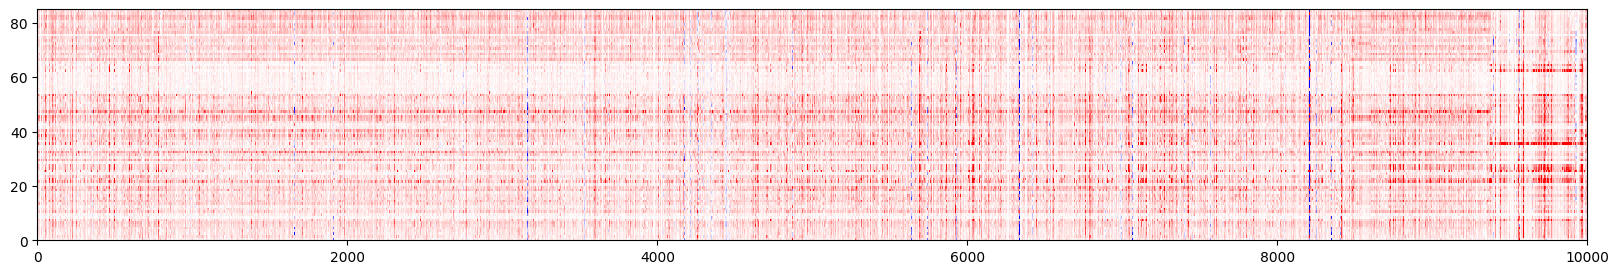

In [57]:
# visualizing a sample of the forgetting association matrix

fig, ax = plt.subplots(figsize=(20,3))
ax.pcolormesh(arr_cat[:,rand_idx], vmin=-0.5, vmax=0.5, cmap='bwr')

## Low-rank approximations of forgetting

In [64]:
# Get rank-1 to rank-5 SVD reconstructions, and their R^2 scores

def fit_svd(fgt):
    results = []
    for rank in [1,2,3,4,5]:
        r2, gt, pred = get_svd_recons_scipy(fgt, full_ds=None, svd_options={'n_factors': rank})
        results.append(pred)
        print(r2)
    return results

In [65]:
# get a subset for faster computation
arr_subset = remove_nan_cols(arr_cat[:, rand_idx])
print(arr_subset.shape)

(85, 9998)


In [66]:
recons_results = fit_svd(arr_subset)

0.5123439443681002
0.6327764914830705
0.7151344296440261
0.7615293601956109
0.7904418270296751


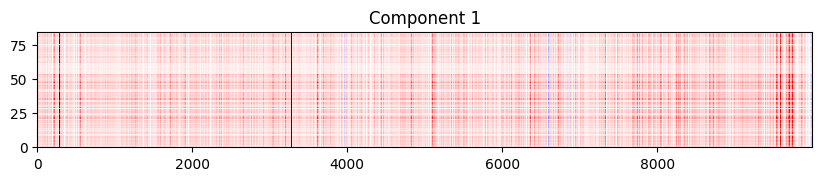

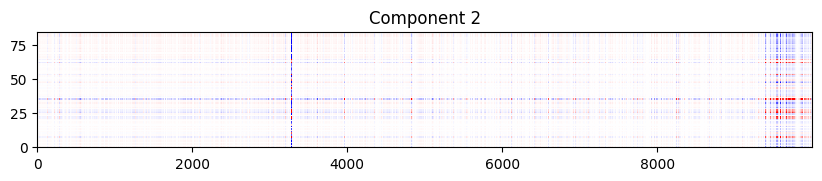

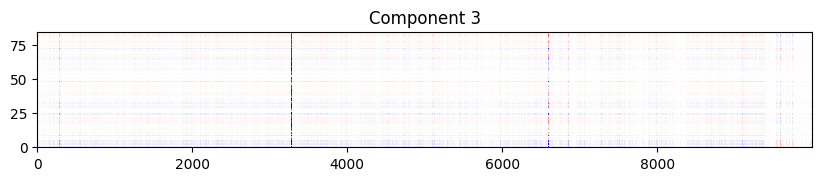

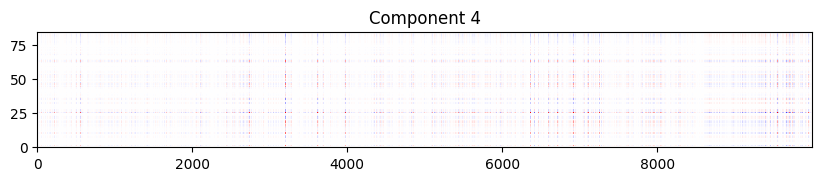

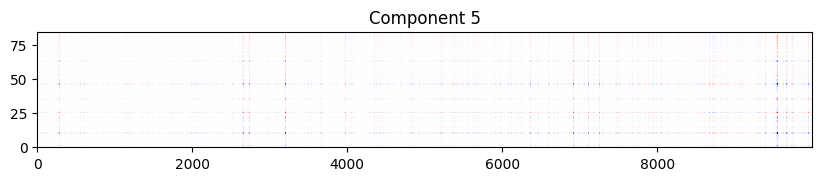

In [70]:
# Visualize the SVD reconstructions

for r, _ in enumerate(recons_results):
    fig, ax = plt.subplots(figsize=(10,1.5))
    ax.pcolormesh(recons_results[r] - recons_results[r-1] if r > 0 else recons_results[r], vmin=-0.5, vmax=0.5, cmap='bwr')
    ax.set_title(f'Component {r+1}')

## Forgetting statistics of OLMo-7B-Instruct

Models are few-shot fine-tuned on MMLU, BBH, TruthfulQA, Dolly, and OLMo2SFT Mix tasks. We use binary exact match drop as the metrics.

In [125]:
from post_process.metric_utils import evaluate_flan_em_arr

In [123]:
# Instance-level raw model predictions on FLAN before any fine-tuning
with open('stats/olmo-7b-ins/pt_base_output_results_dict_train.pkl','rb') as f:
    base_outputs = pickle.load(f)

In [121]:
# The FLAN subset of Tulu from the dataloader
from utils.config import load_configs
config_temp = load_configs('configs/llm/llm_defaults.yaml','configs/llm/ocl_ins/stat_7b_on_flan_v2_train.yaml')
flan_ds = load_raw_ds('train', config_temp, None, 'tulu', None)

In [124]:
print(base_outputs[5000]['prompt'][:200])
print('---')
print(flan_ds[5000][0][:200])

<|endoftext|><|user|>
Explanation and answer: You can travel virtually anywhere in a plane.
yes

The corresponding question: Is the following sentence factually correct?
"One can travel to Cartagena, 
---
Explanation and answer: You can travel virtually anywhere in a plane.
yes

The corresponding question: Is the following sentence factually correct?
"One can travel to Cartagena, Spain in an airplane."


In [127]:
# try computing the EM from raw outputs
em_score_from_raw = evaluate_flan_em_arr(base_outputs, split='train')

In [136]:
# our pre-compute em score
em_score_base = np.load('stats/olmo-7b-ins/train_base_em.npy')
(em_score_base == em_score_from_raw).all()

True

In [140]:
dummy, meta_7b_ins = load_concat_arr('stats/olmo-7b-ins/mbtdo2-ppl-inc.npy')

# EM drops after fine-tuning, over flan examples where base model got correct
fgt_base_correct = np.load('stats/olmo-7b-ins/train_em_fgt_base_correct.npy')

In [142]:
# the forgetting matrix and the ocl task meta info
fgt_base_correct.shape, meta_7b_ins

((142, 4764),
 {'mmlu': {'start': 0,
   'stop': 57,
   'tasks': ['abstract_algebra',
    'anatomy',
    'astronomy',
    'business_ethics',
    'clinical_knowledge',
    'college_biology',
    'college_chemistry',
    'college_computer_science',
    'college_mathematics',
    'college_medicine',
    'college_physics',
    'computer_security',
    'conceptual_physics',
    'econometrics',
    'electrical_engineering',
    'elementary_mathematics',
    'formal_logic',
    'global_facts',
    'high_school_biology',
    'high_school_chemistry',
    'high_school_computer_science',
    'high_school_european_history',
    'high_school_geography',
    'high_school_government_and_politics',
    'high_school_macroeconomics',
    'high_school_mathematics',
    'high_school_microeconomics',
    'high_school_physics',
    'high_school_psychology',
    'high_school_statistics',
    'high_school_us_history',
    'high_school_world_history',
    'human_aging',
    'human_sexuality',
    'international

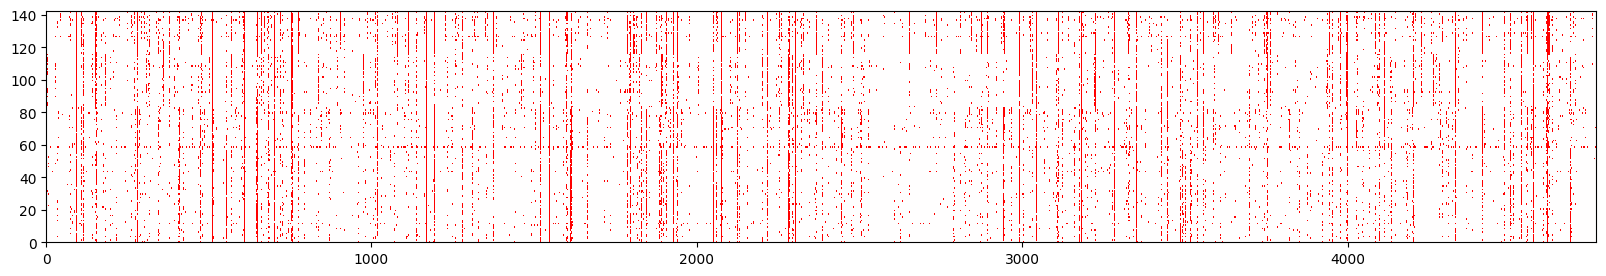

In [143]:
# visualizing the forgetting matrix

fig, ax = plt.subplots(figsize=(20,3))
ax.pcolormesh(fgt_base_correct, vmin=-0.5, vmax=0.5, cmap='bwr')

# Fitting Logistic MF models over the EM drops

In [146]:
from post_process.fit_utils import get_logistic_mf_recons_progressive
all_recons = get_logistic_mf_recons_progressive(fgt_base_correct, 5)

Fitting rank 1
Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900
Fitting rank 2
Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoc

F1: 0.5058525645663026


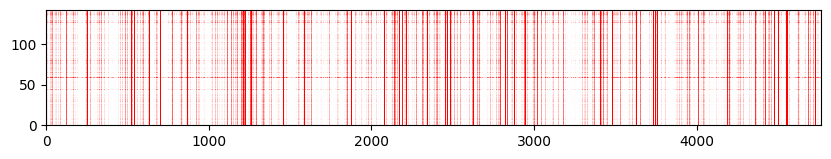

F1: 0.5931524888069528


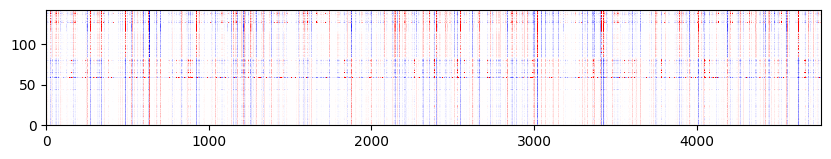

F1: 0.6511253814040777


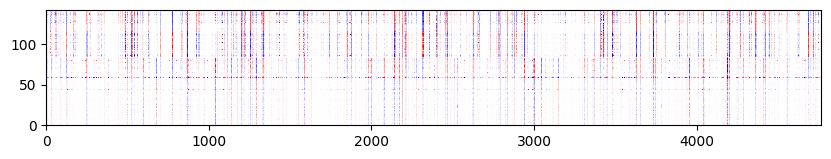

F1: 0.6824518476692389


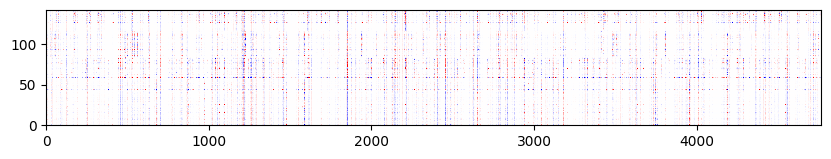

F1: 0.7069646826376883


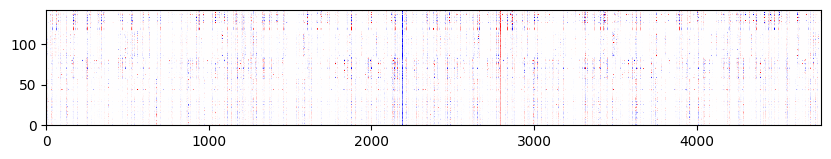

In [ ]:
import sklearn
for k in range(len(all_recons)):
    fig, ax = plt.subplots(figsize=(10,1.5))
    ax.pcolormesh(all_recons[k] - all_recons[k-1] if k else all_recons[k], vmin=-0.5, vmax=0.5, cmap='bwr')
    f1 = sklearn.metrics.f1_score(fgt_base_correct.reshape(-1).astype(int), all_recons[k].reshape(-1) > 0.5)
    print('F1:', f1)
    plt.show()